# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Utility-Functions" data-toc-modified-id="Utility-Functions-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Utility Functions</a></div><div class="lev1 toc-item"><a href="#MNIST" data-toc-modified-id="MNIST-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>MNIST</a></div><div class="lev2 toc-item"><a href="#Deep-Autoencoder" data-toc-modified-id="Deep-Autoencoder-21"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Deep Autoencoder</a></div><div class="lev2 toc-item"><a href="#Shallow-Autoencoder" data-toc-modified-id="Shallow-Autoencoder-22"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Shallow Autoencoder</a></div><div class="lev1 toc-item"><a href="#Denoising-Autoencoder" data-toc-modified-id="Denoising-Autoencoder-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Denoising Autoencoder</a></div><div class="lev1 toc-item"><a href="#Sparse-Autoencoders" data-toc-modified-id="Sparse-Autoencoders-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Sparse Autoencoders</a></div>

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import warnings
import tensorflow

warnings.filterwarnings('ignore')

#from __future__ import print_function
from keras.models import Model
from keras.layers import Dense, Input
from keras.datasets import mnist
from keras.regularizers import l1
#from keras.optimizers import Adam
from tensorflow.keras.optimizers import Adam

# Utility Functions

In [3]:
def plot_autoencoder_outputs(autoencoder, n, dims):
    decoded_imgs = autoencoder.predict(x_test)

    # number of example digits to show
    n = 5
    plt.figure(figsize=(10, 4.5))
    for i in range(n):
        # plot original image
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(x_test[i].reshape(*dims))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        if i == n/2:
            ax.set_title('Original Images')

        # plot reconstruction 
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(decoded_imgs[i].reshape(*dims))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        if i == n/2:
            ax.set_title('Reconstructed Images')
    plt.show()

def plot_loss(history):
    historydf = pd.DataFrame(history.history, index=history.epoch)
    plt.figure(figsize=(8, 6))
    historydf.plot(ylim=(0, historydf.values.max()))
    plt.title('Loss: %.3f' % history.history['loss'][-1])
    
def plot_compare_histories(history_list, name_list, plot_accuracy=True):
    dflist = []
    min_epoch = len(history_list[0].epoch)
    losses = []
    for history in history_list:
        h = {key: val for key, val in history.history.items() if not key.startswith('val_')}
        dflist.append(pd.DataFrame(h, index=history.epoch))
        min_epoch = min(min_epoch, len(history.epoch))
        losses.append(h['loss'][-1])

    historydf = pd.concat(dflist, axis=1)

    metrics = dflist[0].columns
    idx = pd.MultiIndex.from_product([name_list, metrics], names=['model', 'metric'])
    historydf.columns = idx
    
    plt.figure(figsize=(6, 8))

    ax = plt.subplot(211)
    historydf.xs('loss', axis=1, level='metric').plot(ylim=(0,1), ax=ax)
    plt.title("Training Loss: " + ' vs '.join([str(round(x, 3)) for x in losses]))
    
    if plot_accuracy:
        ax = plt.subplot(212)
        historydf.xs('acc', axis=1, level='metric').plot(ylim=(0,1), ax=ax)
        plt.title("Accuracy")
        plt.xlabel("Epochs")
    
    plt.xlim(0, min_epoch-1)
    plt.tight_layout()

# MNIST

## Deep Autoencoder

In [4]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

print(x_train.shape)
print(x_test.shape)

11501568/11490434 [==============================] - 4s 0us/step
(60000, 784)
(10000, 784)


In [5]:
input_size = 784
hidden_size = 128
code_size = 32

input_img = Input(shape=(input_size,))
hidden_1 = Dense(hidden_size, activation='relu')(input_img)
code = Dense(code_size, activation='relu')(hidden_1)
hidden_2 = Dense(hidden_size, activation='relu')(code)
output_img = Dense(input_size, activation='sigmoid')(hidden_2)

autoencoder = Model(input_img, output_img)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder.fit(x_train, x_train, epochs=3)

Epoch 1/3
1875/1875 [==============================] - 43s 9ms/step - loss: 0.1366
Epoch 2/3
1875/1875 [==============================] - 16s 9ms/step - loss: 0.0978
Epoch 3/3
1875/1875 [==============================] - 16s 9ms/step - loss: 0.0924


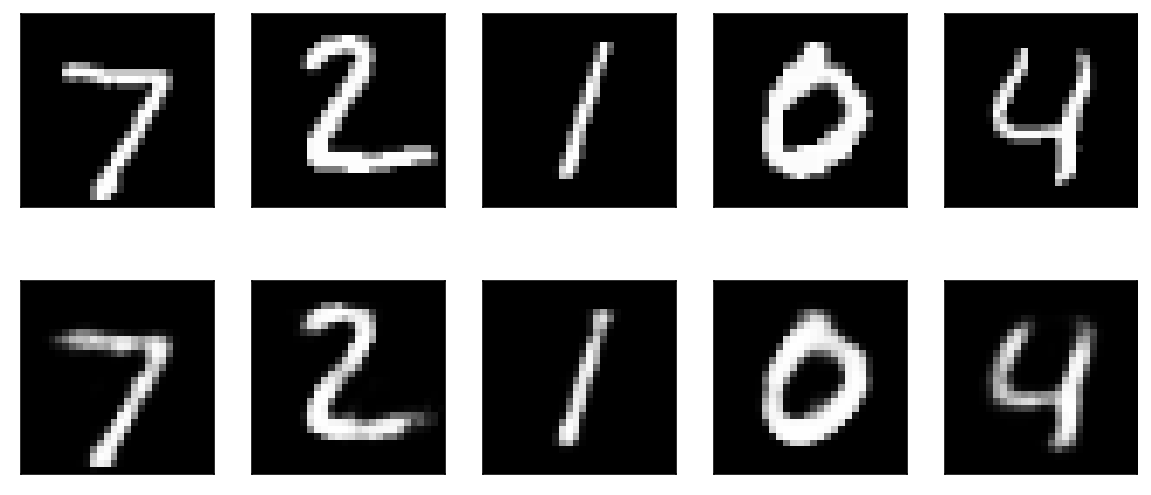

In [6]:
plot_autoencoder_outputs(autoencoder, 5, (28, 28))

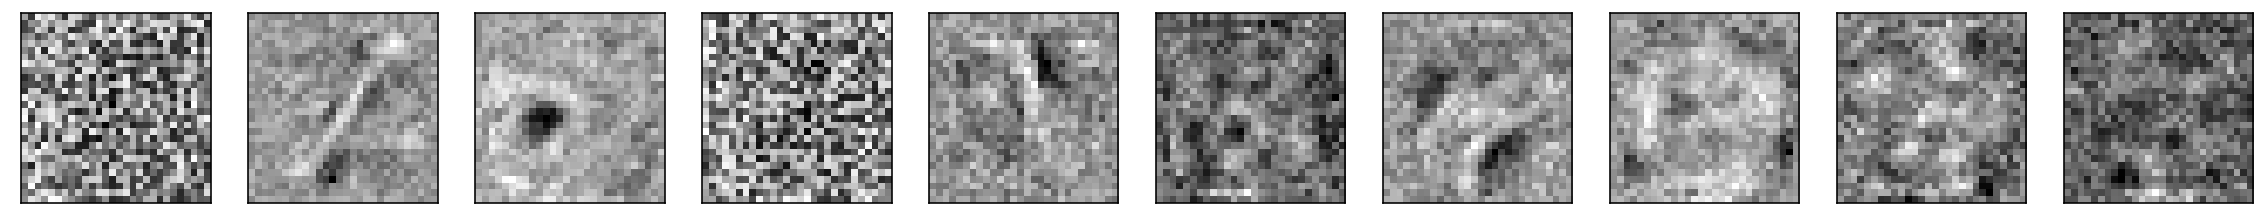

In [7]:
weights = autoencoder.get_weights()[0].T

n = 10
plt.figure(figsize=(20, 5))
for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    plt.imshow(weights[i+0].reshape(28, 28))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    

## Shallow Autoencoder

In [8]:
input_size = 784
code_size = 32

input_img = Input(shape=(input_size,))
code = Dense(code_size, activation='relu')(input_img)
output_img = Dense(input_size, activation='sigmoid')(code)

autoencoder = Model(input_img, output_img)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder.fit(x_train, x_train, epochs=5)

Epoch 1/5
1875/1875 [==============================] - 9s 4ms/step - loss: 0.1614
Epoch 2/5
1875/1875 [==============================] - 9s 5ms/step - loss: 0.1041
Epoch 3/5
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0964
Epoch 4/5
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0951
Epoch 5/5
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0946


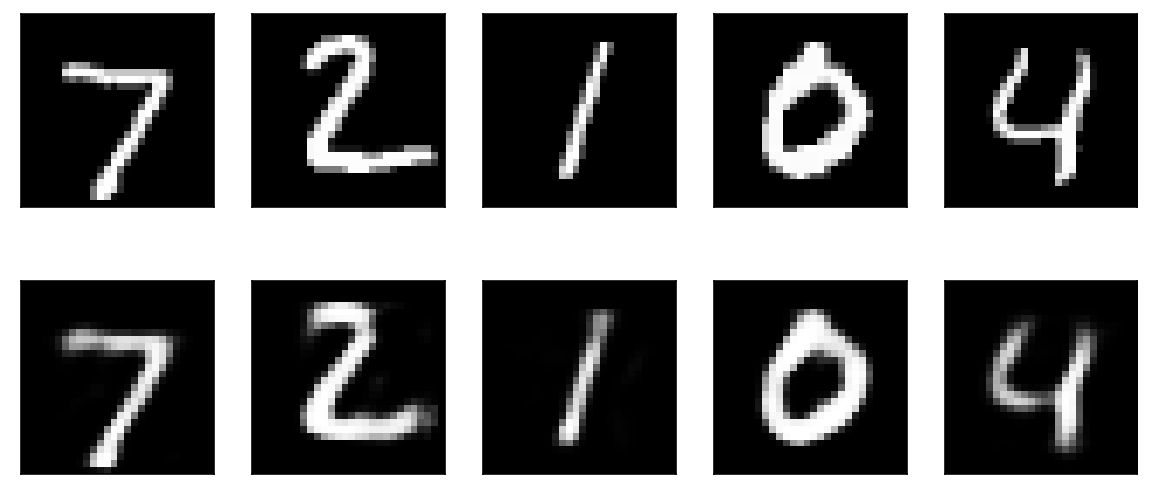

In [9]:
plot_autoencoder_outputs(autoencoder, 5, (28, 28))

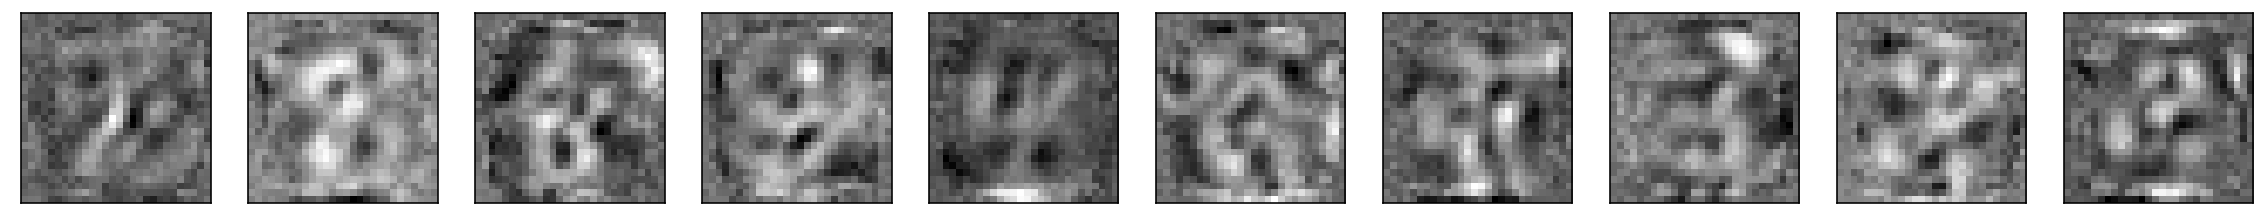

In [10]:
weights = autoencoder.get_weights()[0].T

n = 10
plt.figure(figsize=(20, 5))
for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    plt.imshow(weights[i+20].reshape(28, 28))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

# Denoising Autoencoder

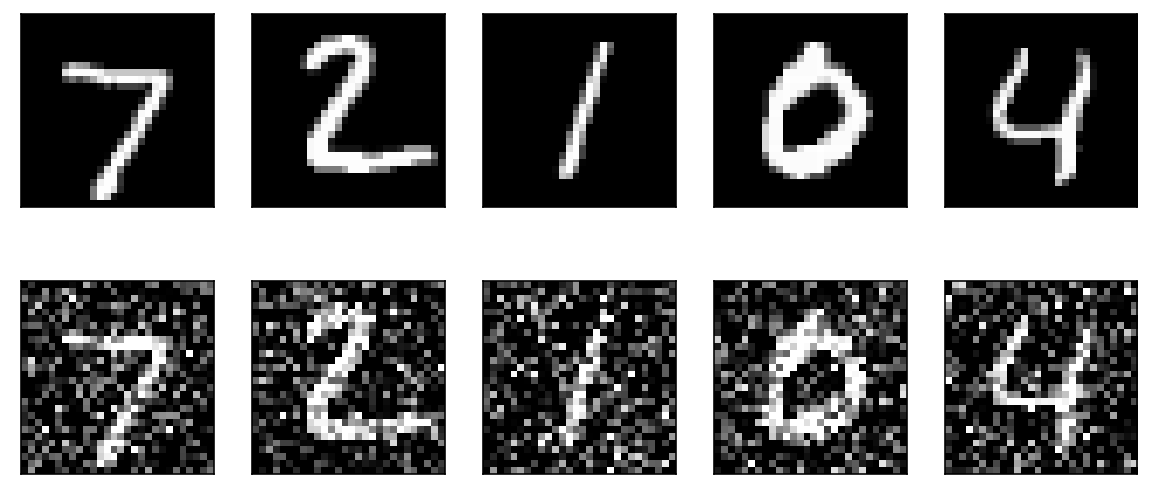

In [11]:
noise_factor = 0.4
x_train_noisy = x_train + noise_factor * np.random.normal(size=x_train.shape) 
x_test_noisy = x_test + noise_factor * np.random.normal(size=x_test.shape)

x_train_noisy = np.clip(x_train_noisy, 0.0, 1.0)
x_test_noisy = np.clip(x_test_noisy, 0.0, 1.0)

n = 5
plt.figure(figsize=(10, 4.5))
for i in range(n):
    # plot original image
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if i == n/2:
        ax.set_title('Original Images')

    # plot noisy image 
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if i == n/2:
        ax.set_title('Noisy Input')

In [12]:
input_size = 784
hidden_size = 128
code_size = 32

input_img = Input(shape=(input_size,))
hidden_1 = Dense(hidden_size, activation='relu')(input_img)
code = Dense(code_size, activation='relu')(hidden_1)
hidden_2 = Dense(hidden_size, activation='relu')(code)
output_img = Dense(input_size, activation='sigmoid')(hidden_2)

autoencoder = Model(input_img, output_img)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder.fit(x_train_noisy, x_train, epochs=10)

Epoch 1/10
1875/1875 [==============================] - 21s 8ms/step - loss: 0.1636
Epoch 2/10
1875/1875 [==============================] - 15s 8ms/step - loss: 0.1272
Epoch 3/10
1875/1875 [==============================] - 15s 8ms/step - loss: 0.1207
Epoch 4/10
1875/1875 [==============================] - 15s 8ms/step - loss: 0.1176
Epoch 5/10
1875/1875 [==============================] - 15s 8ms/step - loss: 0.1156
Epoch 6/10
1875/1875 [==============================] - 15s 8ms/step - loss: 0.1141
Epoch 7/10
1875/1875 [==============================] - 15s 8ms/step - loss: 0.1129
Epoch 8/10
1875/1875 [==============================] - 15s 8ms/step - loss: 0.1120
Epoch 9/10
1875/1875 [==============================] - 15s 8ms/step - loss: 0.1112: 0s - lo
Epoch 10/10
1875/1875 [==============================] - 16s 9ms/step - loss: 0.1106


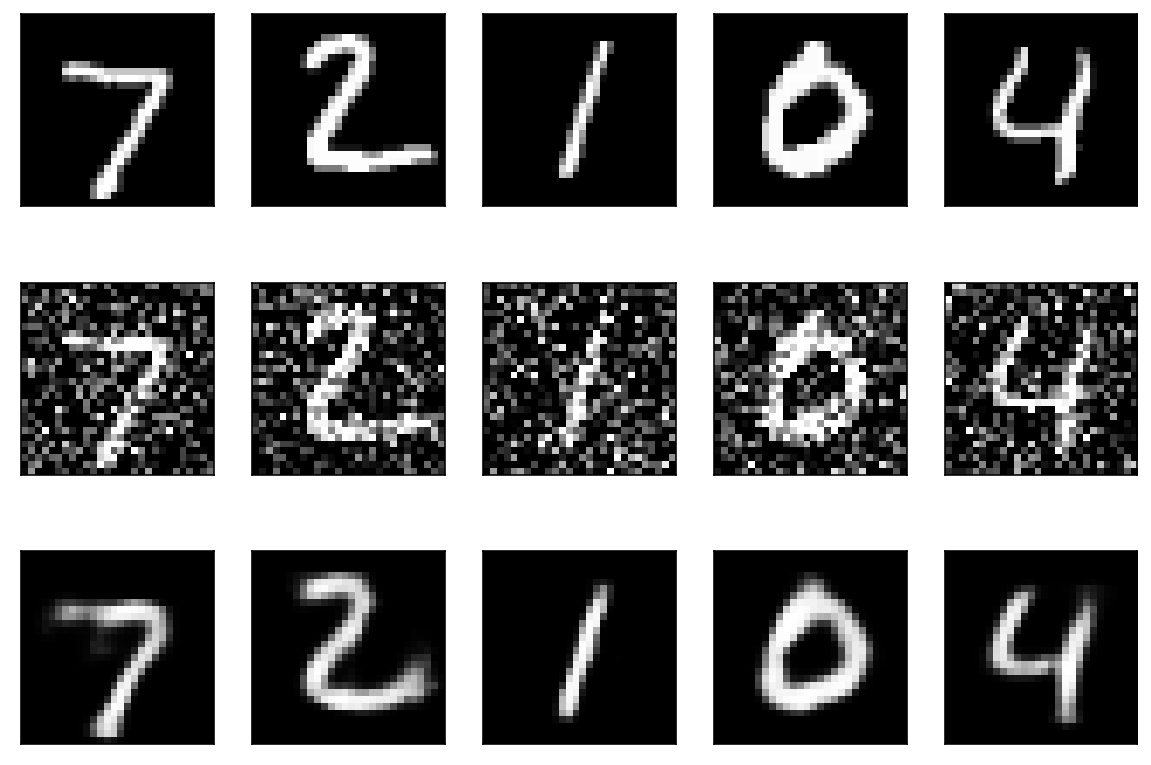

In [13]:
n = 5
plt.figure(figsize=(10, 7))

images = autoencoder.predict(x_test_noisy)

for i in range(n):
    # plot original image
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if i == n/2:
        ax.set_title('Original Images')

    # plot noisy image 
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if i == n/2:
        ax.set_title('Noisy Input')
        
    # plot noisy image 
    ax = plt.subplot(3, n, i + 1 + 2*n)
    plt.imshow(images[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if i == n/2:
        ax.set_title('Autoencoder Output')

# Sparse Autoencoders

In [14]:
input_size = 784
code_size = 32

input_img = Input(shape=(input_size,))
code = Dense(code_size, activation='relu')(input_img)
output_img = Dense(input_size, activation='sigmoid')(code)

autoencoder_standard = Model(input_img, output_img)
autoencoder_standard.compile(optimizer='adam', loss='binary_crossentropy')
history_standard = autoencoder_standard.fit(x_train, x_train, epochs=20)

encoded_standard = Model(input_img, code)

Epoch 1/20
1875/1875 [==============================] - 9s 4ms/step - loss: 0.1622
Epoch 2/20
1875/1875 [==============================] - 8s 4ms/step - loss: 0.1046
Epoch 3/20
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0966
Epoch 4/20
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0952
Epoch 5/20
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0946
Epoch 6/20
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0943
Epoch 7/20
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0942
Epoch 8/20
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0940
Epoch 9/20
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0939
Epoch 10/20
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0938
Epoch 11/20
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0938
Epoch 12/20
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0937
E

In [15]:
input_size = 784
code_size = 32

input_img = Input(shape=(input_size,))
code = Dense(code_size, activation='relu', activity_regularizer=l1(10e-6))(input_img)
output_img = Dense(input_size, activation='sigmoid')(code)

autoencoder_regularized = Model(input_img, output_img)
autoencoder_regularized.compile(optimizer='adam', loss='binary_crossentropy')
history_regularized = autoencoder_regularized.fit(x_train, x_train, epochs=20)

encoded_regularized = Model(input_img, code)

Epoch 1/20
1875/1875 [==============================] - 9s 4ms/step - loss: 0.1638A: 0s - loss: 0.1
Epoch 2/20
1875/1875 [==============================] - 8s 4ms/step - loss: 0.1056
Epoch 3/20
1875/1875 [==============================] - 12s 6ms/step - loss: 0.0987
Epoch 4/20
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0972
Epoch 5/20
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0966
Epoch 6/20
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0962
Epoch 7/20
1875/1875 [==============================] - 12s 6ms/step - loss: 0.0959
Epoch 8/20
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0957
Epoch 9/20
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0955
Epoch 10/20
1875/1875 [==============================] - 12s 6ms/step - loss: 0.0954
Epoch 11/20
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0953
Epoch 12/20
1875/1875 [==============================] - 12s 6ms/

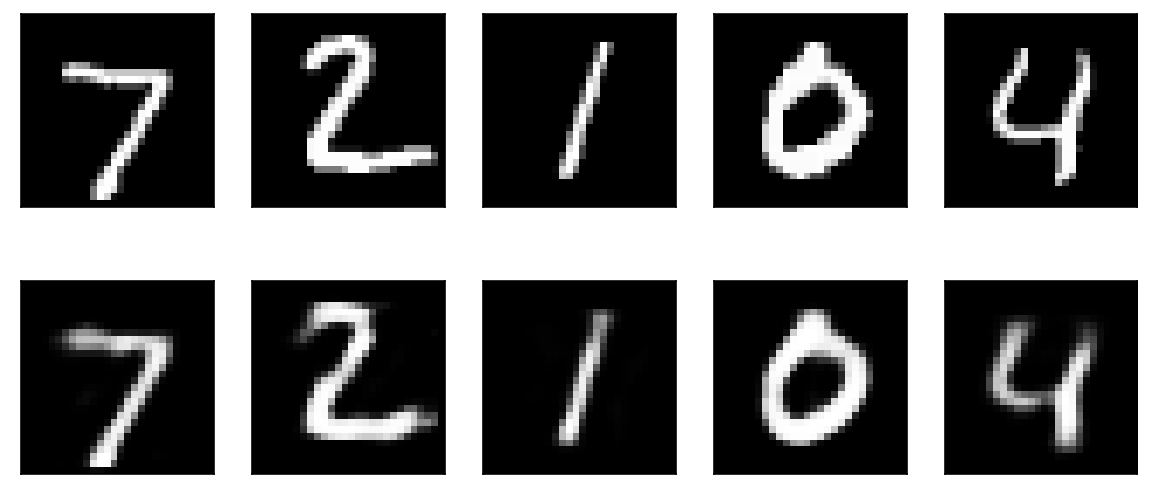

In [16]:
plot_autoencoder_outputs(autoencoder_regularized, 5, (28, 28))

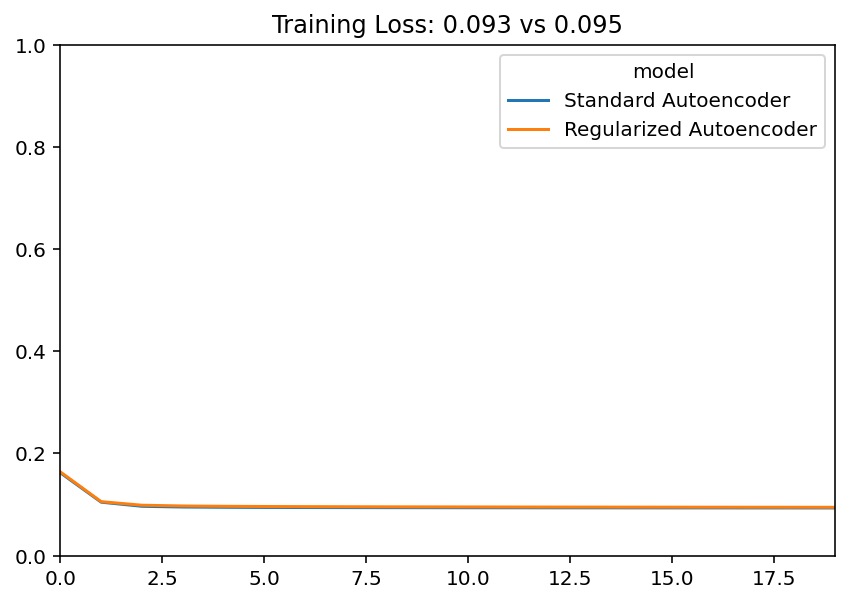

In [17]:
plot_compare_histories([history_standard, history_regularized], 
                       ['Standard Autoencoder', 'Regularized Autoencoder'], plot_accuracy=False)

In [18]:
autoencoder_standard.evaluate(x_test, x_test)

313/313 [==============================] - 4s 3ms/step - loss: 0.0920


0.09203032404184341

In [19]:
autoencoder_regularized.evaluate(x_test, x_test)

313/313 [==============================] - 1s 3ms/step - loss: 0.0935


0.09345201402902603

In [20]:
print(encoded_standard.predict(x_test).mean())
print(encoded_regularized.predict(x_test).mean())

6.614832
4.365832


<AxesSubplot:ylabel='Density'>

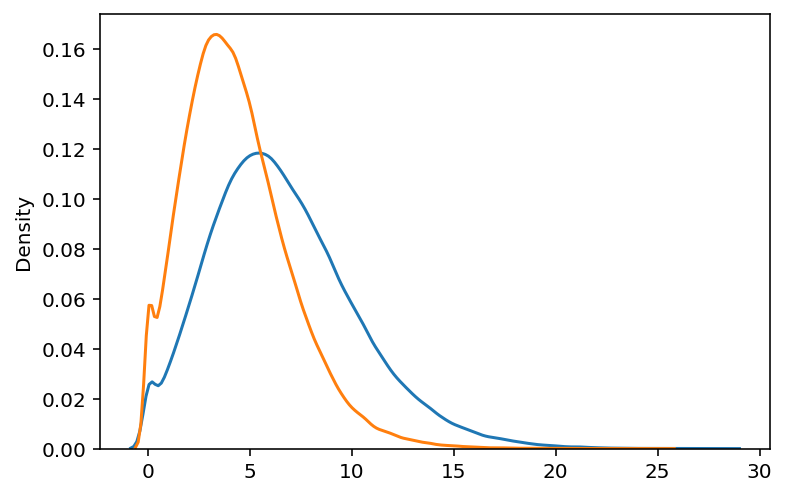

In [21]:
standard_scores = encoded_standard.predict(x_test).ravel()
regularized_scores = encoded_regularized.predict(x_test).ravel()
sns.distplot(standard_scores, hist=False, label='standard model')
sns.distplot(regularized_scores, hist=False, label='regularized model')

<AxesSubplot:ylabel='Density'>

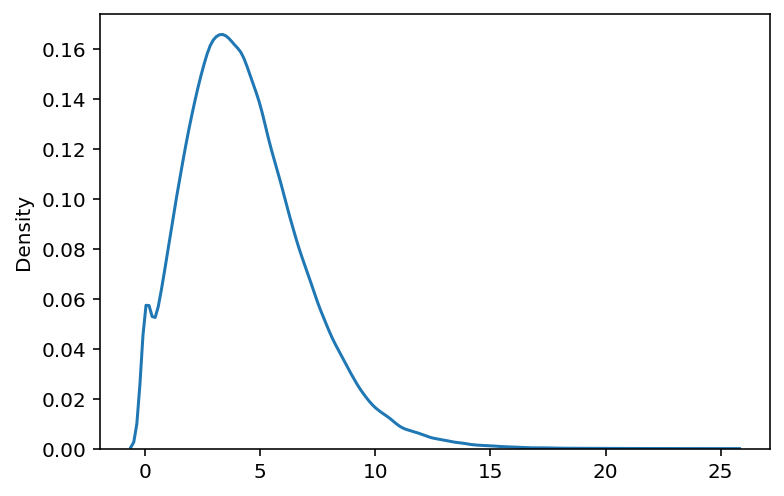

In [22]:
sns.distplot(regularized_scores, hist=False, label='regularized model')